In [25]:
import pandas as pd
import os
import numpy as np
import librosa.display
import IPython
import matplotlib.pyplot as plt
import librosa
from scipy.io.wavfile import read as read_wav
import seaborn as sns
import torchaudio

import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import librosa
import soundfile as sf


In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
# Function to play audio
def play_audio(audio_data, sample_rate):
    import IPython.display as ipd
    ipd.display(ipd.Audio(audio_data, rate=sample_rate))

# Function to plot mel-spectrogram
def plot_mel_spectrogram(mel_spectrogram):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', sr=22050, hop_length=512, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram')
    plt.tight_layout()
    plt.show()

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import librosa

class RandomCNN(nn.Module):
    def __init__(self):
        super(RandomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)  # Assuming 2 classes: major and not major

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def generate_audio_with_model(model, target_class, num_iterations=1000, lr=0.01):
    # Get the input shape from the model
    def get_input_shape(model):
        for layer in model.children():
            if isinstance(layer, nn.Conv2d):
                # Assuming the first Conv2d layer's input shape is representative
                # Batch size is usually not specified, so add 1 for batch dimension
                # Increase the input dimensions to be large enough for pooling operations
                return (1, layer.in_channels, 128, 128)
        raise ValueError("No Conv2d layer found in the model to infer input shape")

   
    input_shape = get_input_shape(model)

    noise = np.random.randn(*input_shape).astype(np.float32)
    noise_tensor = torch.tensor(noise, requires_grad=True)

    # Define optimizer
    optimizer = optim.Adam([noise_tensor], lr=lr)

    # Define binary cross-entropy loss
    bce_loss = nn.BCEWithLogitsLoss()

    # Target class tensor (for BCE, the target is 1 for the desired class, 0 otherwise)
    target_class_tensor = torch.tensor([1.0]) if target_class == 1 else torch.tensor([0.0])

    for iteration in range(num_iterations):
        optimizer.zero_grad()
        output = model(noise_tensor)

        # Use the output corresponding to the target class and ensure the shapes match
        target_output = output[0, target_class].unsqueeze(0)  # Add extra dimension to match target

        # Calculate binary cross-entropy loss
        loss = bce_loss(target_output, target_class_tensor)
        
        loss.backward()
        optimizer.step()

        if iteration % 100 == 0:
            print(f'Iteration {iteration}, Loss: {loss.item()}')

    # Convert the optimized noise to a numpy array
    optimized_noise = noise_tensor.detach().numpy()
    
    # Reshape the optimized noise for mel-spectrogram (example reshape)
    mel_spectrogram = optimized_noise.reshape(input_shape[2], input_shape[3])

    # Convert mel-spectrogram to audio waveform
    inv_mel_spec = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=22050)

    # Get the classification confidence for the generated audio
    noise_tensor = torch.tensor(optimized_noise, requires_grad=False)
    output = model(noise_tensor)
    confidence = torch.sigmoid(output[0, target_class]).item()

    return inv_mel_spec, mel_spectrogram, confidence





In [29]:
# Instantiate the random CNN model
random_model = RandomCNN()

Iteration 0, Loss: 0.6476331949234009
Iteration 100, Loss: 0.1059563159942627
Iteration 200, Loss: 0.04807864502072334
Iteration 300, Loss: 0.028628146275877953
Iteration 400, Loss: 0.019358914345502853
Iteration 500, Loss: 0.014082451350986958
Iteration 600, Loss: 0.010751469060778618
Iteration 700, Loss: 0.008499889634549618
Iteration 800, Loss: 0.006897133309394121
Iteration 900, Loss: 0.005718236323446035
Generated Audio Confidence: 0.9952432513237


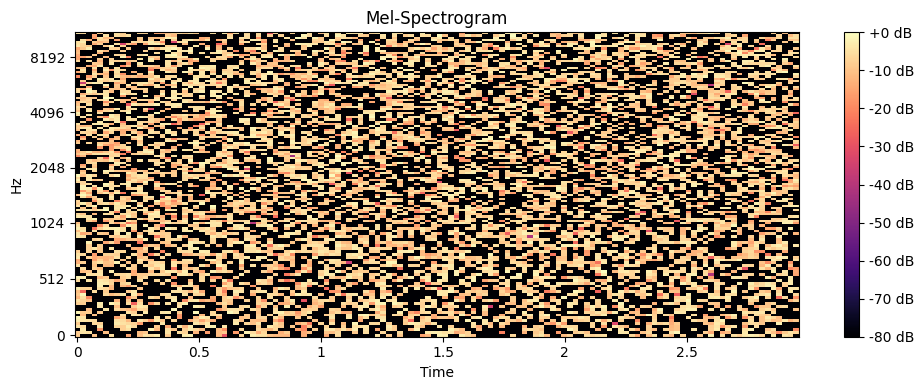

In [30]:
generated_audio, mel_spectrogram, confidence = generate_audio_with_model(random_model, target_class=1)
print(f'Generated Audio Confidence: {confidence}')

# Play the generated audio
play_audio(generated_audio, sample_rate=22050)

# Plot the mel-spectrogram
plot_mel_spectrogram(mel_spectrogram)


In [ ]:
generated_audio, mel_spectrogram, confidence = generate_audio_with_model(random_model, target_class=1)
print(f'Generated Audio Confidence: {confidence}')

# Play the generated audio
play_audio(generated_audio, sample_rate=22050)

# Plot the mel-spectrogram
plot_mel_spectrogram(mel_spectrogram)

Iteration 0, Loss: 0.6437913179397583
Iteration 100, Loss: 0.10121536254882812
Iteration 200, Loss: 0.0462646484375
Iteration 300, Loss: 0.0277712345123291
Iteration 400, Loss: 0.018819808959960938
Iteration 500, Loss: 0.013694286346435547
Iteration 600, Loss: 0.010469436645507812
Iteration 700, Loss: 0.008289337158203125
Iteration 800, Loss: 0.0067310333251953125
Iteration 900, Loss: 0.005579471588134766
Generated Audio Confidence: 0.004692827817052603


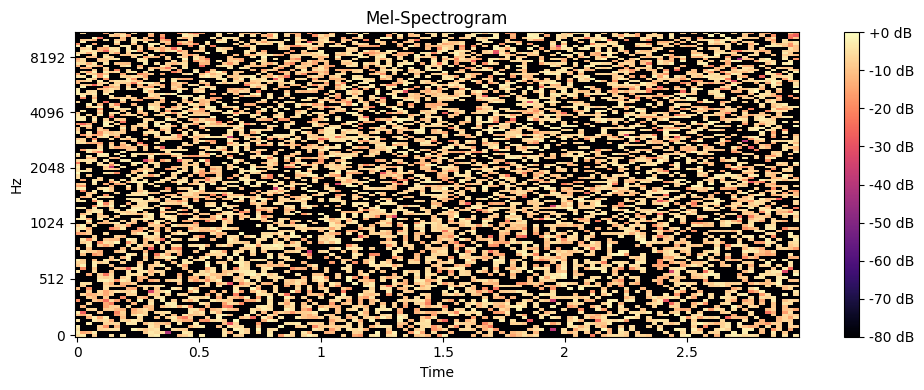

In [31]:
generated_audio, mel_spectrogram, confidence = generate_audio_with_model(random_model, target_class=0)
print(f'Generated Audio Confidence: {confidence}')

# Play the generated audio
play_audio(generated_audio, sample_rate=22050)

# Plot the mel-spectrogram
plot_mel_spectrogram(mel_spectrogram)

In [ ]:
generated_audio, mel_spectrogram, confidence = generate_audio_with_model(random_model, target_class=0)
print(f'Generated Audio Confidence: {confidence}')

# Play the generated audio
play_audio(generated_audio, sample_rate=22050)

# Plot the mel-spectrogram
plot_mel_spectrogram(mel_spectrogram)